In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset, ConcatDataset, SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
from torchvision.models import resnet18
import torchvision
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import cv2
import os

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.model = resnet18(num_classes=10)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        return self.model(x)

In [4]:
data_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = MNIST(download=True, root=".", transform=data_transform, train=True)
test_dataset = MNIST(download=True, root=".", transform=data_transform, train=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 543kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.30MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.96MB/s]


In [5]:
"""
  Function for computing the accuracy of the predictions over the entire DataLoader
"""
def get_accuracy(model, data_loader, device):
    correct = 0
    total = 0

    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100*(correct/total)


In [6]:
"Function for plotting training and validation losses"
def plot_losses(train_acc, valid_acc):
    # change the style of the plots to seaborn
    plt.style.use('seaborn-v0_8-whitegrid')

    train_acc = np.array(train_acc)
    valid_acc = np.array(valid_acc)

    fig, ax = plt.subplots(figsize=(8, 4.5))

    ax.plot(train_acc, color="blue", label="Train_acc")
    ax.plot(valid_acc, color="red", label="Validation_acc")
    ax.set(title="Acc over epochs",
            xlabel="Epoch",
            ylabel="Acc")
    ax.legend()
    fig.show()

    # change the plot style to default
    plt.style.use('default')

In [7]:
"Function for the training step of the training loop"
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # backward and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader)

    return model, optimizer, epoch_loss

In [8]:
"Fucntion for the validation step of the trainig loop"
def validate(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass and record loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

    epoch_loss = running_loss / len(valid_loader)

    return model, epoch_loss

In [9]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    # set object for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    list_train_acc = []
    list_val_acc = []

    # train model
    for epoch in range(0, epochs):
        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)

        if epoch % print_every == print_every - 1:
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)


            print('Epochs: {}, Train_loss: {}, Valid_loss: {}, Train_accuracy: {}, Valid_accuracy: {}'.format(
                    epoch, train_loss, valid_loss, train_acc, valid_acc
                    ))

            list_train_acc.append(train_acc)
            list_val_acc.append(valid_acc)
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)

    plot_losses(list_train_acc, list_val_acc)

    return model, optimizer, (train_losses, valid_losses)

In [10]:
dataset = ConcatDataset([train_dataset, test_dataset])

In [11]:
def setup_dataflow(dataset, train_idx, val_idx):
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)

    return train_loader, val_loader

In [12]:
num_folds = 5
splits = KFold(n_splits=num_folds,shuffle=True,random_state=42)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

############### Fold 1 ###############
Epochs: 0, Train_loss: 0.11219793959301232, Valid_loss: 0.04904202792910991, Train_accuracy: 99.11607142857143, Valid_accuracy: 98.42857142857143
Epochs: 1, Train_loss: 0.037608144654925645, Valid_loss: 0.03872644457674785, Train_accuracy: 99.4, Valid_accuracy: 98.82142857142857
Epochs: 2, Train_loss: 0.028706097860762385, Valid_loss: 0.0422210456451205, Train_accuracy: 99.44107142857142, Valid_accuracy: 98.67857142857143
Epochs: 3, Train_loss: 0.022483521104944105, Valid_loss: 0.03234561344559294, Train_accuracy: 99.68392857142857, Valid_accuracy: 98.96428571428572
Epochs: 4, Train_loss: 0.015069537805850684, Valid_loss: 0.0391603239941562, Train_accuracy: 99.58571428571429, Valid_accuracy: 98.86428571428571
Epochs: 5, Train_loss: 0.01556463165693484, Valid_loss: 0.03726232426566166, Train_accuracy: 99.66428571428571, Valid_accuracy: 98.88571428571429
Epochs: 6, Train_loss: 0.011904398859923407, Valid_loss: 0.04202066833934386, Train_accuracy: 99

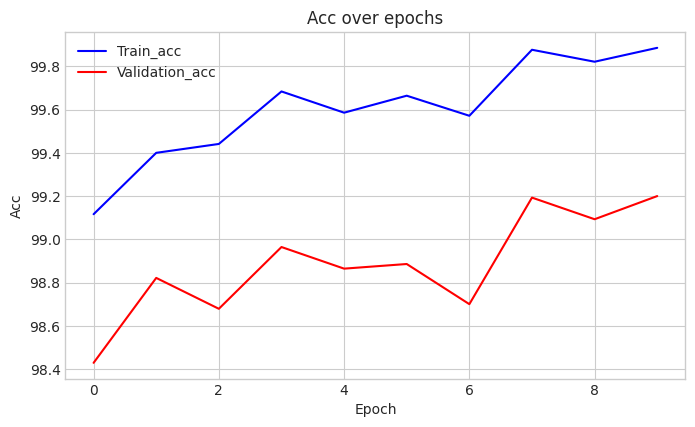

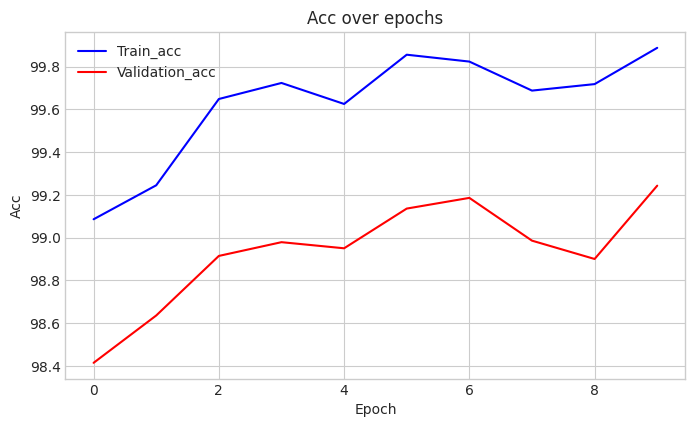

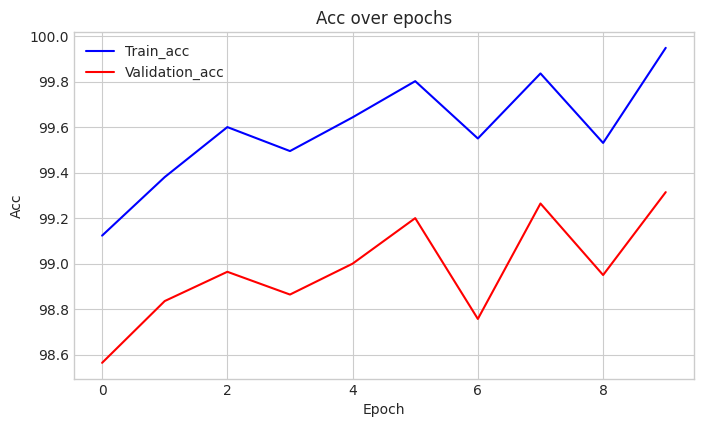

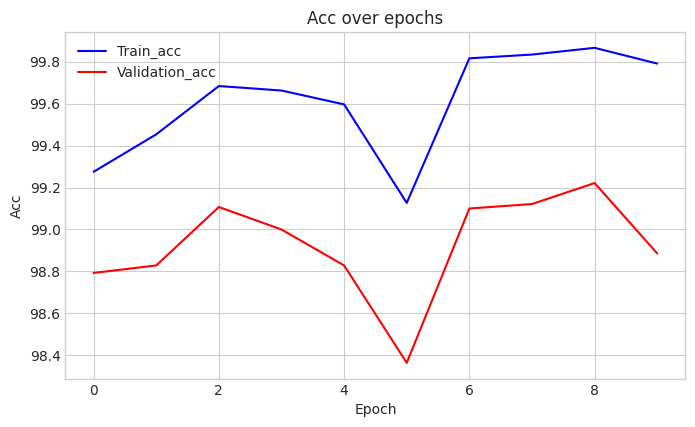

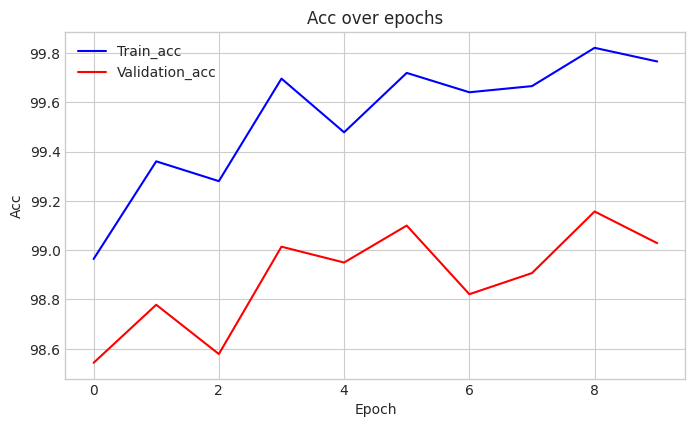

In [14]:
for fold_idx, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):
  print('############### Fold {} ###############'.format(fold_idx + 1))
  train_loader, val_loader = setup_dataflow(dataset, train_idx, val_idx)
  model = Net().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
  loss_function = nn.CrossEntropyLoss()
  model, optimizer, _ = training_loop(model, loss_function, optimizer, train_loader, val_loader, 10, device)


In [15]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
